<a href="https://colab.research.google.com/github/2203A53017/AIML-B-39/blob/main/DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import re

In [14]:
# Load the data
data = pd.read_csv('imdb_anime.csv')

# Display the first few rows of the dataset
data.head()

,Title,Genre,User Rating,Number of Votes,Runtime,Year,Summary,Stars,Certificate,Metascore,Gross,Episode,Episode Title
0,One Piece,"Animation, Action, Adventure",8.9,"187,689",24 min,(1999– ),Follows the adventures of Monkey D. Luffy and ...,"Mayumi Tanaka,Laurent Vernin,Akemi Okamura,Ton...",TV-14,NaN,187689,0,NaN
1,Teenage Mutant Ninja Turtles: Mutant Mayhem,"Animation, Action, Adventure",7.4,"28,895",99 min,(2023),The film follows the Turtle brothers as they w...,NaN,PG,74,28895,0,NaN
2,The Super Mario Bros. Movie,"Animation, Adventure, Comedy",7.1,"189,108",92 min,(2023),A plumber named Mario travels through an under...,NaN,PG,46,189108,0,NaN
3,Attack on Titan,"Animation, Action, Adventure",9.1,"434,457",24 min,(2013–2023),After his hometown is destroyed and his mother...,"Josh Grelle,Bryce Papenbrook,Yûki Kaji,Yui Ish...",TV-MA,NaN,434457,0,NaN
4,Jujutsu Kaisen,"Animation, Action, Adventure",8.5,"82,909",24 min,(2020– ),A boy swallows a cursed talisman - the finger ...,"Junya Enoki,Yûichi Nakamura,Adam McArthur,Yuma...",TV-MA,NaN,82909,0,NaN


In [15]:
# Drop unwanted columns
cols_to_drop = ['Runtime', 'Summary', 'Stars', 'Certificate', 'Metascore', 'Gross', 'Episode', 'Episode Title']
data = data.drop(columns=cols_to_drop)

# Handle missing values
data = data.dropna()

# One-hot encoding genres
genres = data['Genre'].str.get_dummies(sep=', ').drop(columns='Animation')
data = pd.concat([data, genres], axis=1).drop(columns='Genre')

# If 'Number of Votes' appears as a row value, we can drop that row.
data = data[data['Number of Votes'] != 'Number of Votes']

# Extract the starting year from the 'Year' column
data['Year'] = data['Year'].str.extract('(\d{4})').astype(int)

# Convert to the desired data types
data['Number of Votes'] = data['Number of Votes'].str.replace(',', '').astype(int)
data['User Rating'] = data['User Rating'].astype(float)

# Calculate the aggregated 'User Rating' weighted by 'Number of Votes' and sum 'Number of Votes'
rating_data = data.groupby('Title').apply(lambda df: pd.Series({
    'User Rating': (df['User Rating'] * df['Number of Votes']).sum() / df['Number of Votes'].sum(),
    'Number of Votes': df['Number of Votes'].sum()
})).reset_index()

# Drop duplicates in the original data to get one row per title
genre_data = data.drop(columns=['User Rating', 'Number of Votes']).drop_duplicates(subset='Title')

# Merge the two dataframes on 'Title'
data = pd.merge(rating_data, genre_data, on='Title')

# Sort the data based on the 'User Rating' in descending order
data = data.sort_values(by='User Rating', ascending=False)

# Convert 'Number of Votes' to integers
data['Number of Votes'] = data['Number of Votes'].astype(int)

# Display the data
data.head()

,Title,User Rating,Number of Votes,Year,Action,Adventure,Biography,Comedy,Crime,Documentary,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War
5217,Show Time!,9.800000,5,2022,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
628,Beyblade Burst QuadStrike,9.400000,46,2023,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
464,Attack on Titan,9.243009,3177533,2013,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3036,King of Fighters '96 Neo-Geo Collection,9.200000,21,1997,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4755,Ramayana: The Legend of Prince Rama,9.200000,25594,1993,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Calculate the weighted rating

# C is the mean rating of all animes
C = data['User Rating'].mean()

# m is the 90th percentile of the number of votes (minimum votes required to be listed)
m = data['Number of Votes'].quantile(0.90)

# The resulting rating is a balance between individual and global rating.
data['User Rating'] = data.apply(lambda x: (x['Number of Votes']/(x['Number of Votes']+m) * x['User Rating']) + (m/(m+x['Number of Votes']) * C), axis=1)

# Sort the animes based on the weighted rating
data = data.sort_values('User Rating', ascending=False)

# Display the top 10 anime
data.head(10)

,Title,User Rating,Number of Votes,Year,Action,Adventure,Biography,Comedy,Crime,Documentary,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War
464,Attack on Titan,9.239324,3177533,2013,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1903,Fullmetal Alchemist: Brotherhood,8.920233,491964,2009,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
708,Bleach: Thousand-Year Blood War,8.909528,123693,2022,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6483,Vinland Saga,8.870947,257626,2019,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4755,Ramayana: The Legend of Prince Rama,8.819257,25594,1993,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1245,Death Note,8.764839,868678,2006,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5428,Steins;Gate,8.730782,146537,2011,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1096,Cowboy Bebop,8.730310,338476,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1275,Demon Slayer: Kimetsu no Yaiba - Tsuzumi Mansi...,8.685338,42478,2021,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2601,Hunter x Hunter,8.683230,463138,2011,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


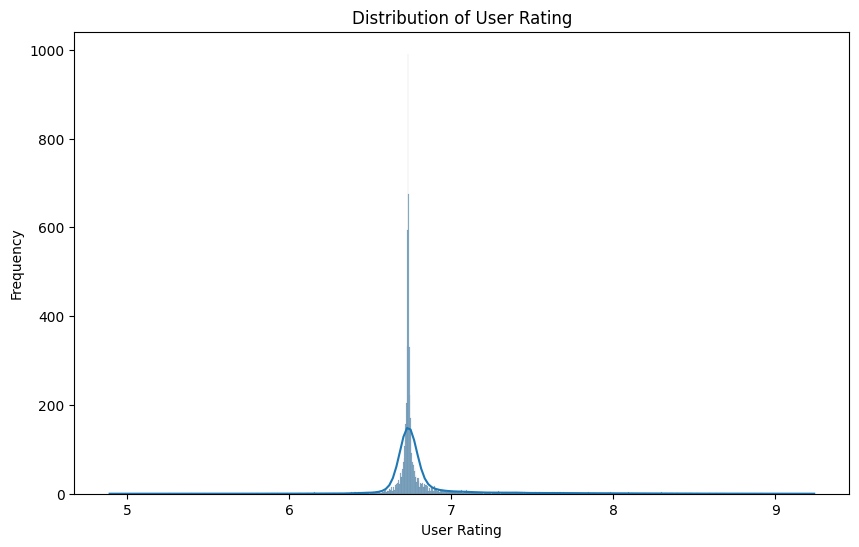

In [17]:
# Distribution of User Rating
plt.figure(figsize=(10, 6))
sns.histplot(data['User Rating'], kde=True)
plt.title('Distribution of User Rating')
plt.xlabel('User Rating')
plt.ylabel('Frequency')
plt.show()

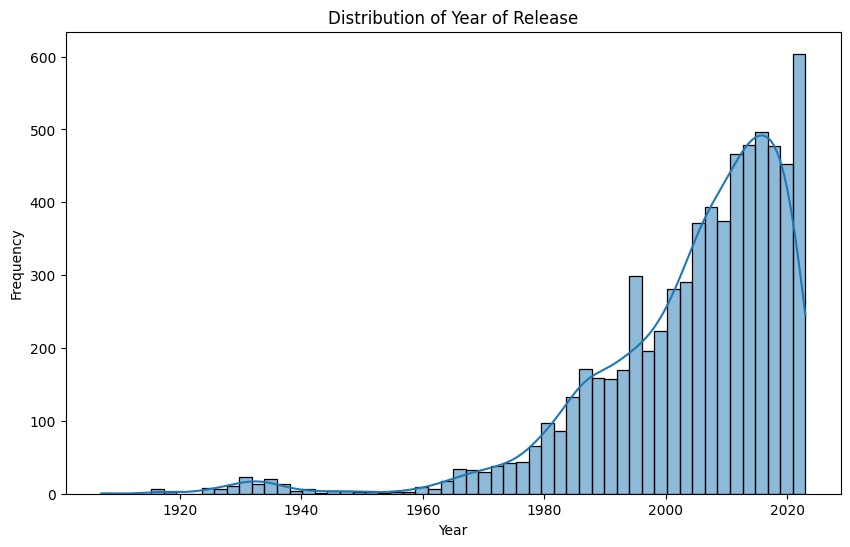

In [18]:
# Distribution of Year of Release
plt.figure(figsize=(10, 6))
sns.histplot(data['Year'], kde=True)
plt.title('Distribution of Year of Release')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

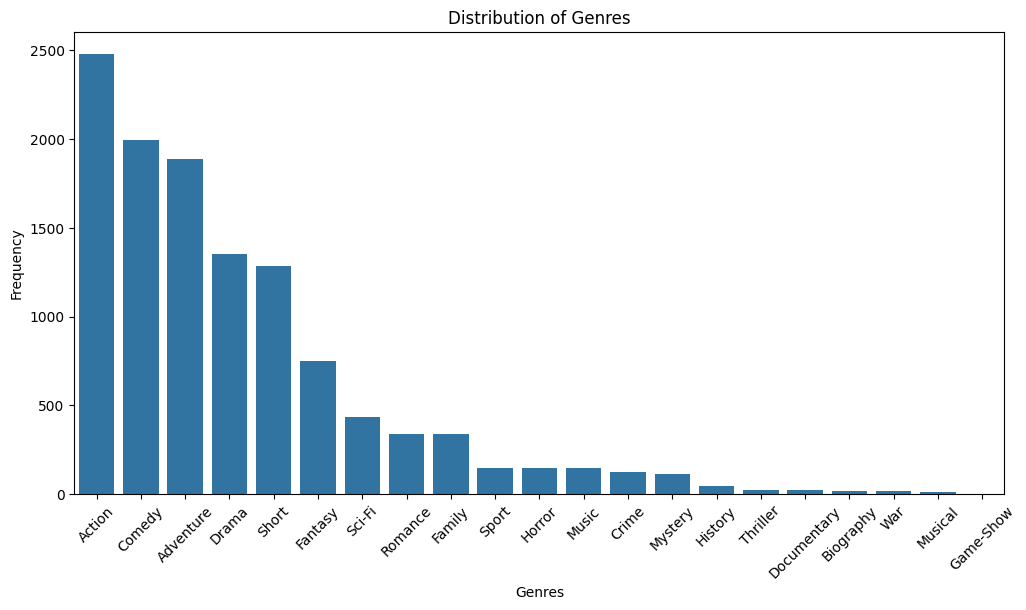

In [19]:
# Distribution of Genres
genre_columns = data.columns[4:]
genre_counts = data[genre_columns].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Distribution of Genres')
plt.ylabel('Frequency')
plt.xlabel('Genres')
plt.xticks(rotation=45)
plt.show()

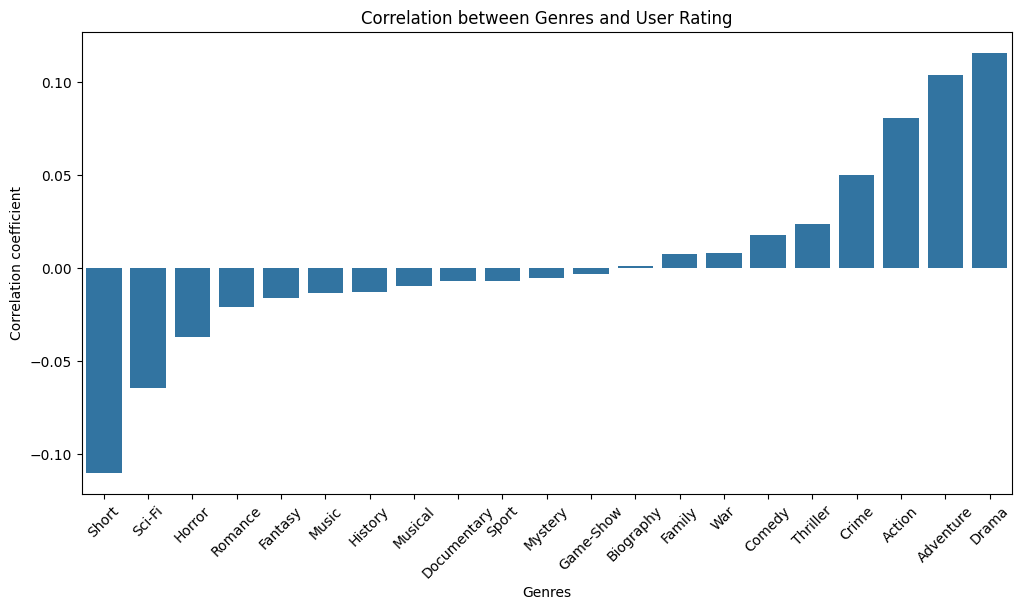

In [20]:
# Calculating the correlation between genres and user rating
correlations = data[genre_columns].apply(lambda x: x.corr(data['User Rating'])).sort_values()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Correlation between Genres and User Rating')
plt.ylabel('Correlation coefficient')
plt.xlabel('Genres')
plt.xticks(rotation=45)
plt.show()

In [21]:
# Extracting genres with significant correlation (|correlation| > 0.01)
significant_genres = correlations[correlations.abs() > 0.01]

# Displaying the top genres that have the most positive impact on ratings
top_positive_genres = significant_genres[significant_genres > 0].sort_values(ascending=False)
print("Genres with the most positive impact on ratings:")
print(top_positive_genres)

Genres with the most positive impact on ratings:
Drama        0.115659
Adventure    0.104048
Action       0.080565
Crime        0.050104
Thriller     0.023721
Comedy       0.017823
dtype: float64


In [22]:
# Splitting the data into train and test sets
from sklearn.model_selection import train_test_split

X = data[genre_columns]
y = data['User Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Training a linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Calculating the RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculating the R^2 score
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error of predictions based on genres: {rmse:.2f}")
print(f"R^2 Score of predictions based on genres: {r2:.2f}")

Root Mean Squared Error of predictions based on genres: 0.30
R^2 Score of predictions based on genres: 0.03
